<a href="https://colab.research.google.com/github/capofwesh20/Analysis-of-NHTSA-complaints/blob/main/Associative_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install fpgrowth_py
!pip install wordcloud

# **Importance of Topic Modeling**

Not all entries might have accurately labeled component descriptions, or some complaints might involve multiple components. Topic modeling can help identify such cases by grouping complaints into topics based on the textual content of the complaints themselves, offering a way to check and refine the categorization of complaints.

Topic modeling can help identify new or emerging trends in vehicle complaints that might not yet be well-represented in your component descriptions. This can be particularly valuable for detecting new issues early on.

Improving Customer Service and Product Development:
Understanding the variety and frequency of topics discussed in complaints can inform customer service strategies and product development. It helps prioritize issues that are most significant to customers and identify areas for improvement in vehicle design and features.

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()  # Prepare tqdm to work with pandas apply()
import spacy
from collections import Counter
import fpgrowth_py.fpgrowth as fpgrowth
from wordcloud import WordCloud

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Classroom/modified_data.csv')

In [ ]:
df.head()

,Complain ID,MANUFACTURER'S NAME,VEHICLE MAKE,VEHICLE MODEL,MODEL YEAR,WAS VEHICLE INVOLVED IN A CRASH,WAS VEHICLE INVOLVED IN A FIRE,NUMBER OF PERSONS INJURED,NUMBER OF FATALITIES,SPECIFIC COMPONENT'S DESCRIPTION,CONSUMER'S CITY,CONSUMER'S STATE CODE,VEHICLE MILEAGE AT FAILURE,DESCRIPTION OF THE COMPLAINT,WAS INCIDENT REPORTED TO POLICE,ANTI-LOCK BRAKES,CRUISE CONTROL,VEHICLE SPEED,WAS VEHICLE TOWED,Year
0,1633294,Honda (American Honda Motor Co.),HONDA,ACCORD,2018.0,N,N,0,0,SERVICE BRAKES,PHILADELPHIA,PA,4.0,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN...",N,N,N,68.0,N,2019
1,1633295,Honda (American Honda Motor Co.),HONDA,ACCORD,2018.0,N,N,0,0,ELECTRICAL SYSTEM,PHILADELPHIA,PA,4.0,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN...",N,N,N,68.0,N,2019
2,1633296,Honda (American Honda Motor Co.),HONDA,ACCORD,2018.0,N,N,0,0,ENGINE,PHILADELPHIA,PA,4.0,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN...",N,N,N,68.0,N,2019
3,1633297,Ford Motor Company,FORD,EXPLORER,2020.0,N,N,0,0,ELECTRICAL SYSTEM,MEHERRIN,VA,5300.0,DEEP SLEEP MODE ACTIVATES AFTER 2 DAYS. MOST ...,N,N,N,0.0,N,2019
4,1633298,"General Motors, LLC",CHEVROLET,VOLT,2017.0,N,N,0,0,SERVICE BRAKES,SAN ANTONIO,TX,15000.0,"WHILE DRIVING ON CITY STREETS AND HIGHWAYS, TH...",N,N,N,70.0,N,2019


In [ ]:
df.shape

(1448058, 20)

In [ ]:
selected_df = df[['Complain ID', 'VEHICLE MAKE', 'VEHICLE MODEL', 'DESCRIPTION OF THE COMPLAINT', 'SPECIFIC COMPONENT\'S DESCRIPTION']]


In [ ]:
selected_df.head()

,Complain ID,VEHICLE MAKE,VEHICLE MODEL,DESCRIPTION OF THE COMPLAINT,SPECIFIC COMPONENT'S DESCRIPTION
0,1633294,HONDA,ACCORD,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN...",SERVICE BRAKES
1,1633295,HONDA,ACCORD,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN...",ELECTRICAL SYSTEM
2,1633296,HONDA,ACCORD,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN...",ENGINE
3,1633297,FORD,EXPLORER,DEEP SLEEP MODE ACTIVATES AFTER 2 DAYS. MOST ...,ELECTRICAL SYSTEM
4,1633298,CHEVROLET,VOLT,"WHILE DRIVING ON CITY STREETS AND HIGHWAYS, TH...",SERVICE BRAKES


Functions to extract Noun and Noun Phrases from DESCRIPTION OF THE COMPLAINT

In [ ]:

from tqdm.auto import tqdm
import spacy
from collections import Counter

# Initialize tqdm progress bar for pandas apply()
tqdm.pandas()



# Load the English model from spaCy
nlp_1 = spacy.load("en_core_web_sm")

# Define your specific stopwords including numbers as strings
specific_stopwords = set([
    '1', '2', '3', '4', '5', '6', '7', '8', '9','0',  # Numbers as strings
    'failure', 'vehicle', 'vehicles', 'problem', 'car', 'ford', 'manufacturer',
    'dealer', 'consumer', 'driver', 'time', 'times', 'issue',
    'model', 'make', 'recall', 'system', 'complaint', 'safety', 'service',
    'reported', 'called', 'told', 'said', 'repair', 'replace', 'fixed',
    'mileage', 'year', 'model year', 'incident', 'occurred', 'happened',
    'experience', 'action', 'process', 'technical',
    'reflective', 'specific', 'general', 'term', 'nhtsa', 'ga', '.', '*'
])


# Update spaCy's default stopwords with the specific stopwords
for word in specific_stopwords:
    nlp_1.vocab[word].is_stop = True

# Ensure all stopwords are recognized as such by spaCy
for word in specific_stopwords:
    lexeme = nlp_1.vocab[word]
    lexeme.is_stop = True

#Function to extract lemmatized nouns not in specific stopwords
def extract_lemmatized_nouns(text):
    # Convert text to lowercase before processing
    text = text.lower()
    doc = nlp_1(text)
    lemmatized_nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN" and token.lemma_ not in specific_stopwords]
    return lemmatized_nouns


def extract_noun_phrases(text):
    text = text.lower()
    doc = nlp_1(text)
    # Use list comprehension to filter noun chunks without stopwords
    noun_phrases = [chunk.text for chunk in doc.noun_chunks if not any(token.is_stop for token in chunk)]
    return noun_phrases



# Function to create a DataFrame with Complaint ID, Vehicle Model, and Keywords


def createNounPhraseDF(modelDF):
    # Create a copy of the DataFrame to avoid modifying the original DataFrame
    resultDF = modelDF.copy()


    resultDF.loc[:, 'Keywords'] = resultDF['DESCRIPTION OF THE COMPLAINT'].progress_apply(extract_noun_phrases)

    # Select and rename the columns as needed
    resultDF = resultDF[['Complain ID', 'VEHICLE MODEL', 'Keywords']]

    return resultDF

def createNounDF(modelDF):
    # Create a copy of the DataFrame to avoid modifying the original DataFrame
    resultDF = modelDF.copy()


    resultDF.loc[:, 'Keywords'] = resultDF['DESCRIPTION OF THE COMPLAINT'].progress_apply(extract_lemmatized_nouns)

    # Select and rename the columns as needed
    resultDF = resultDF[['Complain ID', 'VEHICLE MODEL', 'Keywords']]

    return resultDF


In [ ]:
print(nlp_1.vocab['*jb'].is_stop)  # Should print True
print(nlp_1.vocab['*ak'].is_stop)  # Should also print True

True
True


In [ ]:
# subset_df = selected_df.iloc[:10000]


In [ ]:
filtered_df = selected_df[selected_df['VEHICLE MAKE'] == 'FORD']
noun_df = createNounDF(filtered_df)
noun_df.head()

  0%|          | 0/237234 [00:00<?, ?it/s]

,Complain ID,VEHICLE MODEL,Keywords
3,1633297,EXPLORER,"[sleep, mode, day, day]"
26,1633320,F-350,"[steering, oscillation, death, curve, mph, bum..."
28,1633322,ESCAPE,"[tow, home, gear, transmission, mile]"
48,1633342,FOCUS,"[tire, affinity, p195/60r15, t, mile, warranty..."
57,1633351,F-150,[software]


In [ ]:
noun_df.rename(columns={
    'Keywords': 'Noun'
}, inplace=True)

In [ ]:
noun_df.head()

,Complain ID,VEHICLE MODEL,Noun
3,1633297,EXPLORER,"[sleep, mode, day, day]"
26,1633320,F-350,"[steering, oscillation, death, curve, mph, bum..."
28,1633322,ESCAPE,"[tow, home, gear, transmission, mile]"
48,1633342,FOCUS,"[tire, affinity, p195/60r15, t, mile, warranty..."
57,1633351,F-150,[software]


In [ ]:
filtered_df_1 = selected_df[selected_df['VEHICLE MAKE'] == 'FORD']
noun_phrases_df = createNounPhraseDF(filtered_df_1)
noun_phrases_df.head()


  0%|          | 0/237234 [00:00<?, ?it/s]

,Complain ID,VEHICLE MODEL,Keywords
3,1633297,EXPLORER,[deep sleep mode]
26,1633320,F-350,"[55 mph, forsyth co., video]"
28,1633322,ESCAPE,"[pch, gears]"
48,1633342,FOCUS,"[july, affinity, p195/60r15 87t, mentioned tir..."
57,1633351,F-150,[new software]


Turning the dataframes into a "one noun per row" format for easier exploration and analysis

In [ ]:
noun_phrases_df.rename(columns={
    'Keywords': 'Noun Phrases'
}, inplace=True)

In [ ]:
noun_phrases_df.head()

,Complain ID,VEHICLE MODEL,Noun Phrases
3,1633297,EXPLORER,[deep sleep mode]
26,1633320,F-350,"[55 mph, forsyth co., video]"
28,1633322,ESCAPE,"[pch, gears]"
48,1633342,FOCUS,"[july, affinity, p195/60r15 87t, mentioned tir..."
57,1633351,F-150,[new software]


# Turning the dataframes into a "one noun per row" format for easier exploration and analysis

In [ ]:
#noun_row_df = noun_df.explode('Noun')
noun_phrase_row_df = noun_phrases_df.explode('Noun Phrases')

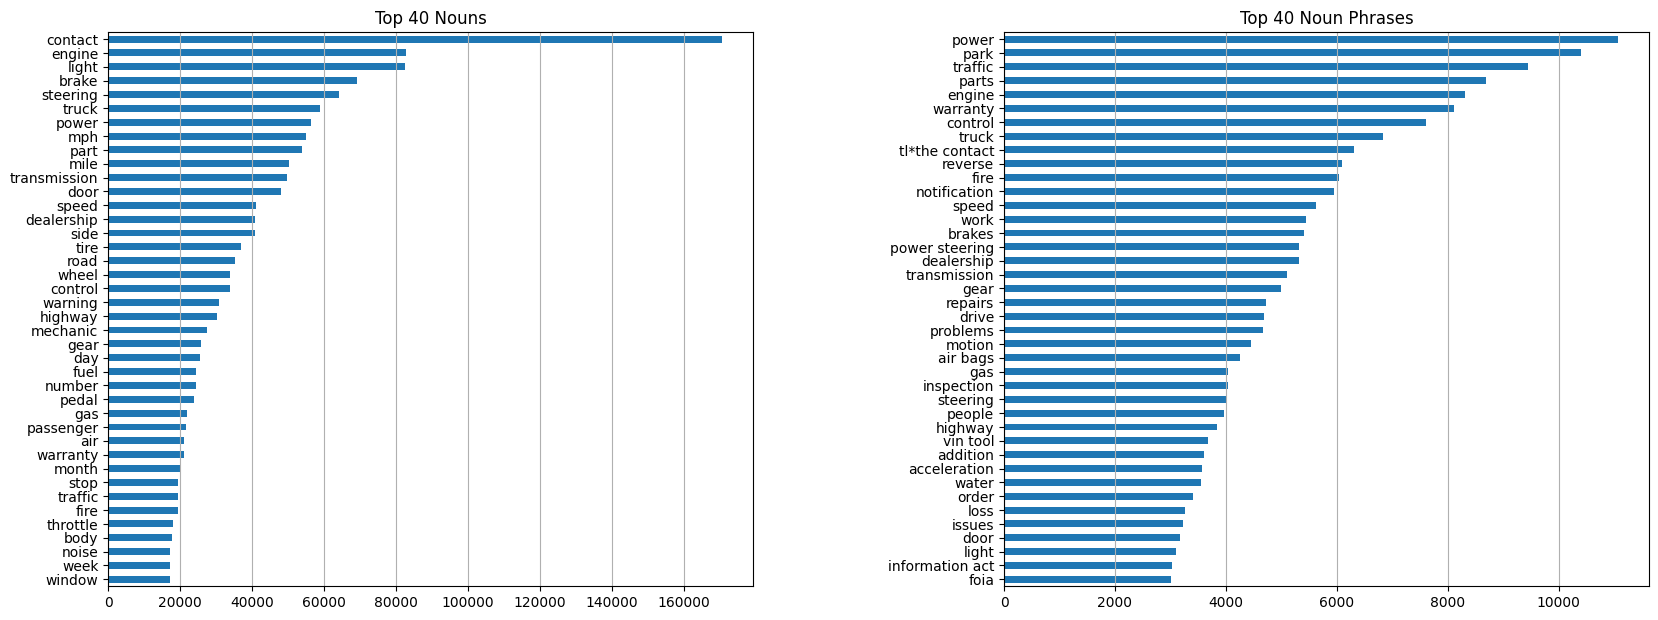

In [ ]:

figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))
figure.tight_layout(pad=15)
noun_row_df['Noun'].value_counts().head(40).sort_values().plot(kind='barh', ax=ax1)
ax1.title.set_text('Top 40 Nouns')
ax1.xaxis.grid(True)
noun_phrase_row_df['Noun Phrases'].value_counts().head(40).sort_values().plot(kind='barh', ax=ax2)
ax2.title.set_text('Top 40 Noun Phrases')
ax2.xaxis.grid(True)

plt.show()


# **Findings**

Noun phrases yield more specific insights than nouns on their own. For example, parts appear in the list, such as brake pedal and steering wheel. In the noun analysis, it is not clear what wheel or brake refers to. Also, highway speed is extracted as a single phrase in the noun phrase analysis whereas it is split between highway and speed in the noun analysis.

# **Run association rule mining on (vehicle model, noun/noun phrase) pairs**

To get to the specific nouns, the notebook limits the rule generation to:

(model, noun) pairs that appear more than 100 times. This is done by setting the minimum support for a rule in the minSupRatio attribute. This removes rules that contain very infrequent nouns that only occur in a small number of complaints.
When a certain noun appears, you want the model to appear at least 25% of the time or more. This is done by setting the minimum confidence for a rule in the minConf attribute. This removes rules that contain nouns that appear in many models at the same time.

In [ ]:
modelNounList = noun_row_df[['VEHICLE MODEL', 'Noun']].values.tolist()
len(modelNounList)  # the total number of (model, noun) pairs

4223011

In [ ]:
min_support = 100 / len(modelNounList)
min_support

2.367978676825611e-05

In [ ]:
freqItemSet, rules = fpgrowth(modelNounList, minSupRatio=min_support, minConf=0.25)

In [ ]:
rules

[[{'focus'}, {'FOCUS'}, 0.9705882352941176],
 [{'shaking'}, {'F-250'}, 0.75],
 [{'interstate'}, {'F-250'}, 0.5795454545454546],
 [{'escape'}, {'ESCAPE'}, 0.9813084112149533],
 [{'coolant'}, {'ESCAPE'}, 0.6548672566371682],
 [{'wobble'}, {'F-250'}, 0.7936507936507936],
 [{'fusion'}, {'FUSION'}, 0.9841269841269841],
 [{'lane'}, {'F-250'}, 0.4961832061068702],
 [{'end'}, {'F-250'}, 0.5851851851851851],
 [{'gear'}, {'F-150'}, 0.3313253012048193],
 [{'fuel'}, {'FOCUS'}, 0.3107344632768362],
 [{'tire'}, {'F-250'}, 0.3423913043478261],
 [{'bump'}, {'F-250'}, 0.7792207792207793],
 [{'transmission'}, {'FOCUS'}, 0.35815602836879434],
 [{'part'}, {'F-250'}, 0.3523489932885906],
 [{'door'}, {'EDGE'}, 0.2916666666666667],
 [{'death'}, {'F-250'}, 0.740506329113924],
 [{'control'}, {'F-250'}, 0.3088235294117647],
 [{'highway'}, {'F-250'}, 0.4413145539906103],
 [{'wheel'}, {'F-250'}, 0.3524027459954233],
 [{'road'}, {'F-250'}, 0.46709129511677283],
 [{'engine'}, {'ESCAPE'}, 0.31275720164609055],
 [{'p

Identify the rules for the F-150 pickup truck. The number included in the rule is the confidence. For example, when the noun speedometer appears in 10 complaint descriptions, 6 of them will be about the F-150. Hence, the rule confidence is 0.60.

In [ ]:
for rule in rules:
    if 'F-250' in rule[1]:
        print(rule)

[{'shaking'}, {'F-250'}, 0.75]
[{'interstate'}, {'F-250'}, 0.5795454545454546]
[{'wobble'}, {'F-250'}, 0.7936507936507936]
[{'lane'}, {'F-250'}, 0.4961832061068702]
[{'end'}, {'F-250'}, 0.5851851851851851]
[{'tire'}, {'F-250'}, 0.3423913043478261]
[{'bump'}, {'F-250'}, 0.7792207792207793]
[{'part'}, {'F-250'}, 0.3523489932885906]
[{'death'}, {'F-250'}, 0.740506329113924]
[{'control'}, {'F-250'}, 0.3088235294117647]
[{'highway'}, {'F-250'}, 0.4413145539906103]
[{'wheel'}, {'F-250'}, 0.3524027459954233]
[{'road'}, {'F-250'}, 0.46709129511677283]
[{'speed'}, {'F-250'}, 0.42655935613682094]
[{'mile'}, {'F-250'}, 0.31438127090301005]
[{'mph'}, {'F-250'}, 0.47092198581560285]
[{'truck'}, {'F-250'}, 0.49794661190965095]


# **Show the nouns that are specific to a model**
Collect the nouns and create a tree map to show the nouns, sized by the rule confidence

In [ ]:
# Collect the nouns found in the association rules for <model>.
# Show the nouns in a word cloud, sized by the rule confidence.
def show_rules_for_model(rules, model):
    modelDict = {}
    for rule in rules:
        if model in rule[1]:
            noun=next(iter(rule[0]))
            if model.lower() not in noun: # we don't want to include the model name itself in the word cloud
                modelDict[noun] = int(rule[2]*1000)
    wc_a = WordCloud(width=700, height=200, background_color ='white',colormap='tab10', prefer_horizontal=0.9).generate_from_frequencies(modelDict)
    figure, ax1 = plt.subplots(ncols=1, figsize=(11,7))
    figure.tight_layout()
    ax1.imshow(wc_a, interpolation="bilinear")
    ax1.axis("off")
    ax1.title.set_text("Correlated terms for " + model)
    plt.show()

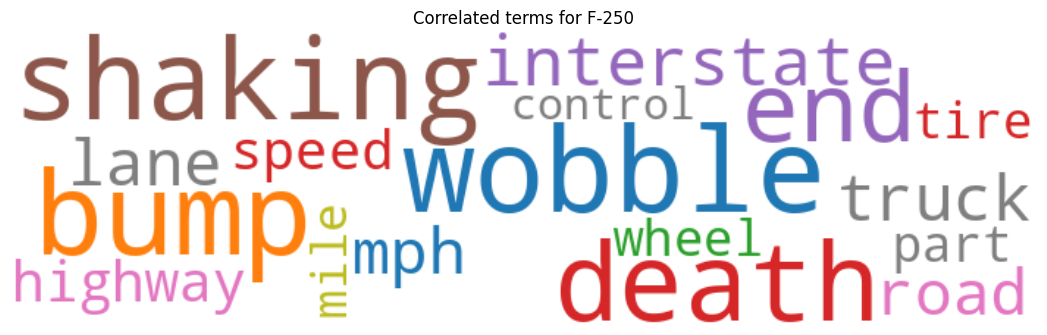

In [ ]:
show_rules_for_model(rules, 'F-250')

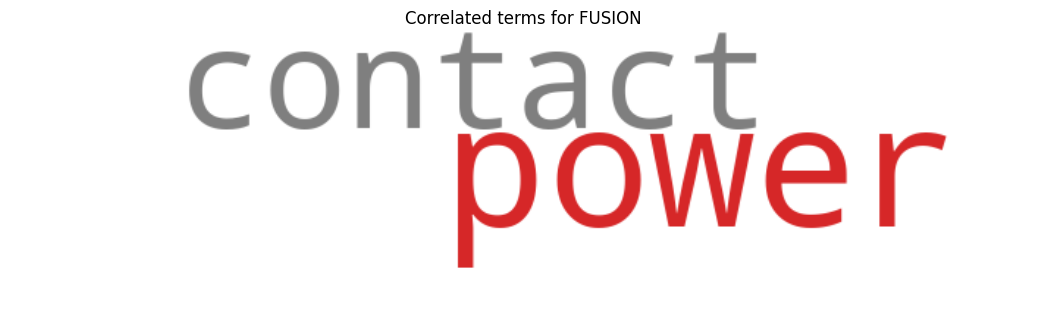

In [ ]:
show_rules_for_model(rules, 'FUSION')

Doing the same for Noun Phrases

In [ ]:
modelNounPhraseList = noun_phrase_row_df[['VEHICLE MODEL', 'Noun Phrases']].values.tolist()
len(modelNounPhraseList)

1148566

In [ ]:
min_support_np = 100 / len(modelNounPhraseList)
min_support_np

8.706508811857569e-05

In [ ]:
np_freqItemSet, np_rules = fpgrowth(modelNounPhraseList, minSupRatio=min_support_np, minConf=0.25)

In [ ]:
rules

[[{'focus'}, {'FOCUS'}, 0.9705882352941176],
 [{'shaking'}, {'F-250'}, 0.75],
 [{'interstate'}, {'F-250'}, 0.5795454545454546],
 [{'escape'}, {'ESCAPE'}, 0.9813084112149533],
 [{'coolant'}, {'ESCAPE'}, 0.6548672566371682],
 [{'wobble'}, {'F-250'}, 0.7936507936507936],
 [{'fusion'}, {'FUSION'}, 0.9841269841269841],
 [{'lane'}, {'F-250'}, 0.4961832061068702],
 [{'end'}, {'F-250'}, 0.5851851851851851],
 [{'gear'}, {'F-150'}, 0.3313253012048193],
 [{'fuel'}, {'FOCUS'}, 0.3107344632768362],
 [{'tire'}, {'F-250'}, 0.3423913043478261],
 [{'bump'}, {'F-250'}, 0.7792207792207793],
 [{'transmission'}, {'FOCUS'}, 0.35815602836879434],
 [{'part'}, {'F-250'}, 0.3523489932885906],
 [{'door'}, {'EDGE'}, 0.2916666666666667],
 [{'death'}, {'F-250'}, 0.740506329113924],
 [{'control'}, {'F-250'}, 0.3088235294117647],
 [{'highway'}, {'F-250'}, 0.4413145539906103],
 [{'wheel'}, {'F-250'}, 0.3524027459954233],
 [{'road'}, {'F-250'}, 0.46709129511677283],
 [{'engine'}, {'ESCAPE'}, 0.31275720164609055],
 [{'p

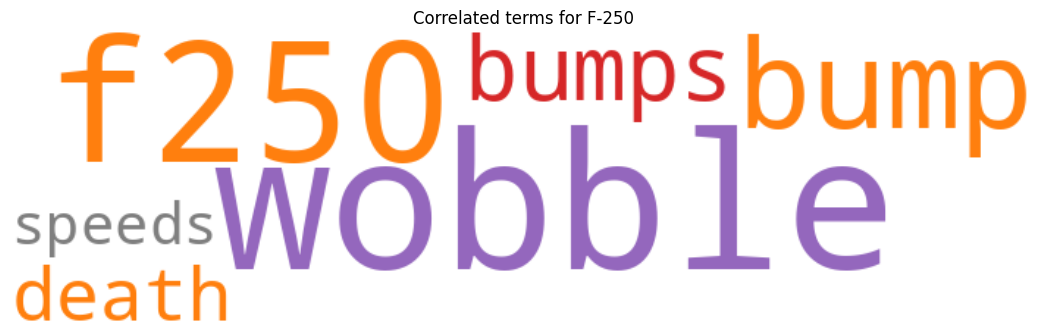

In [ ]:
show_rules_for_model(np_rules, 'F-250')

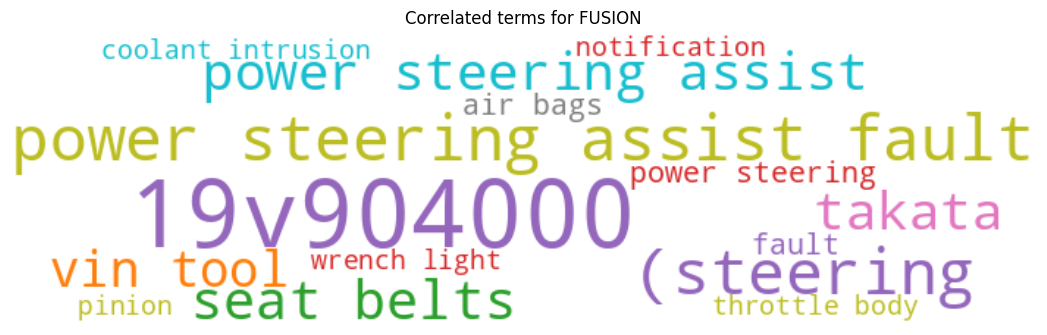

In [ ]:
show_rules_for_model(np_rules, 'FUSION')

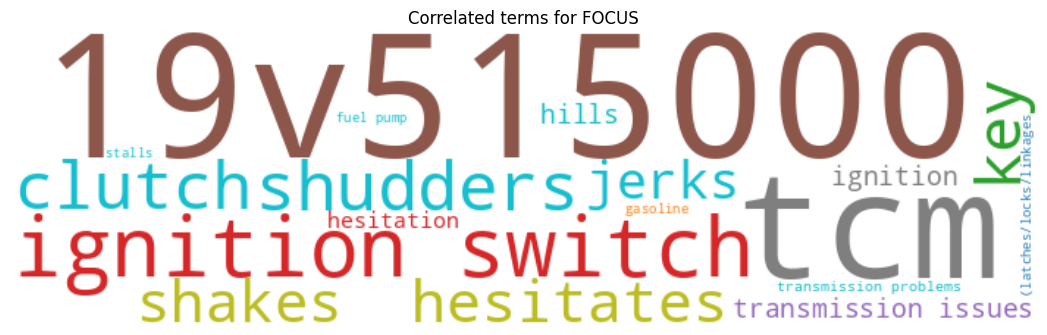

In [ ]:
show_rules_for_model(np_rules, 'FOCUS')

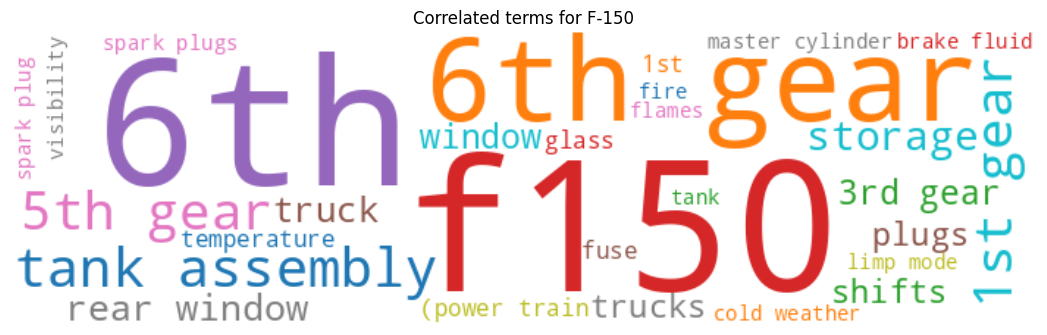

In [ ]:
show_rules_for_model(np_rules, 'F-150')

# **Summary**

This notebook demonstrates how  NLP techniques, such as extraction of nouns and noun phrases can yield significant insights:

**The Part_Of_Speech** detection using Spacy NLP Syntax block is used to focus on specific word types (in this case, nouns). The lemma detection ensures that all variants (such as "wiper", "wipers", etc. ) are combined into a single entry.
The Noun Phrase block extracts additional terms, which provide more insigts as compared to single nouns (for example, "power steering" vs. "steering").

**Association Rule Mining** can be used to correlate text analysis results with structured data (in this case, the car model). In this case, it highlighted model-specific problems (such as the "power steering" reported for F-250 trucks)